In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from urllib.parse import urlencode, quote_plus
# token = 'VYWwAEEAbtDwRwHeSHvRgn8dM0BmquNFZcD80b6t' # leahdzuckerman@gmail.com
# token = 'p23MxTBd9a6oELSfYOuRqOiyLR2E4v0WWeRyC1a7' # leah.zuckerman@gmail.com
# token = '0dCo6aRU7tZb2IRSFiGv1mFDEUUlX1SeeX0daqS6' # stephen.cholvat@gmail.com
# token = 'XvcA0uWArSHzJVU1iuys6ew4ChZ56kYf6GcRuFZ6' # anna@nwlink.com
token = 'twNua1LhNOoTxhPvt6dYcu8jA3uUH47kUjmVrgLc' # stephen.c.holvat@gmail.com
# token = 'LJNMK1LzWK7OQyR5W6hfWOcmwMUmwHEf7mLab55g' # leah.dzuckerman@gmail.com

##### ADS Data

In [82]:
'''
Get data for a large number of publications from ADS 'search' endpoint
 - Only 2000 results can be returned at once, so we need to loop to get more
 - Let's use max 1000 because we cant do more than 1000 requests/day to metrics endpoint, and pulling data from metrics (see below) has to be done individually
'''

fields = ['bibcode', 'doi', 'author_count', 'aff', 'bibstem', 'citation_count', 'arxiv_class', 'year']
query = "database:astronomy year:2010-2025"
subject_to  = "database:astronomy arxiv_class:astro-ph*"
encoded_query = urlencode({'q': query, 'fq': subject_to, 'fl': ','.join(fields)})
data = pd.DataFrame(columns =fields)
N_tot = 999
count = 0
while count < N_tot:
    results = requests.get("https://api.adsabs.harvard.edu/v1/search/query?{encoded_query}&rows={rows}" \
                            "&start={start}".format(encoded_query=encoded_query,rows=5000,start=0), \
                            headers={'Authorization': 'Bearer ' + token})
    docs = results.json()['response']['docs'] # list of n = rows dictionaries
    for row in docs:
        if count < N_tot:
            for s in row['doi']:
                if 'arXiv' in s:
                    doi = s
            bibcode = row['bibcode']
            author_count  = row['author_count'] if 'author_count' in row.keys() else None
            affiliation  = row['aff'] if 'aff' in row.keys() else None
            bibstem  = row['bibstem'] if 'bibstem' in row.keys() else None
            arxiv_class  = row['arxiv_class'] if 'arxiv_class' in row.keys() else None
            citation_count  = row['citation_count'] if 'citation_count' in row.keys() else None
            year  = row['year'] if 'year' in row.keys() else None
            data.loc[len(data)] = {'bibcode':bibcode, 'doi':doi, 'author_count':author_count, 'aff':affiliation, 'bibstem':bibstem, 'citation_count':citation_count, 'arxiv_class': arxiv_class, 'year': year}
            count += 1

print('Total records returned:', count)
print('Total requests remaining:', results.headers['X-RateLimit-Remaining'])
data.to_csv('../ads_data2.csv', index=False)
display(data)

Total records returned: 999
Total requests remaining: 4999


,bibcode,doi,author_count,aff,bibstem,citation_count,arxiv_class,year
0,2021arXiv210508081T,10.48550/arXiv.2105.08081,2,"[-, -]","[arXiv, arXiv2105]",5,"[astro-ph.EP, astro-ph.IM, physics.pop-ph]",2021
1,2020A&A...641A...6P,10.48550/arXiv.1807.06209,182,"[-, Institut d'Astrophysique Spatiale, CNRS, U...","[A&A, A&A...641]",14623,[astro-ph.CO],2020
2,2024ApJ...962L..15J,10.48550/arXiv.2401.10502,2,"[Southwest Research Institute, Boulder, CO 803...","[ApJL, ApJL..962]",7,[astro-ph.SR],2024
3,2016A&A...594A..13P,10.48550/arXiv.1502.01589,262,"[-, School of Physics and Astronomy, Cardiff U...","[A&A, A&A...594]",12517,[astro-ph.CO],2016
4,2013PASP..125..306F,10.48550/arXiv.1202.3665,4,"[-, -, -, -]","[PASP, PASP..125]",10133,"[astro-ph.IM, physics.comp-ph, stat.CO]",2013
...,...,...,...,...,...,...,...,...
994,2011Ap&SS.332....1R,10.48550/arXiv.1101.5036,1,"[IESL, Foundation for Research and Technology-...","[Ap&SS, Ap&SS.332]",488,[astro-ph.HE],2011
995,2010AJ....139.2360S,10.48550/arXiv.1004.1167,48,"[Department of Astronomy and Astrophysics, The...","[AJ, AJ....139]",886,[astro-ph.CO],2010
996,2010ApJ...721.1014M,10.48550/arXiv.1004.0276,13,"[Department of Astronomy, University of Washin...","[ApJ, ApJ...721]",572,[astro-ph.CO],2010
997,2010Natur.468.1080M,10.48550/arXiv.1011.4918,5,"[National Research Council Canada, Herzberg In...","[Natur, Natur.468]",740,[astro-ph.EP],2010


In [86]:
'''
Add features pulled from ADS 'metrics' endpoint for each puplication (using stored bibcodes)
    - 'read_count' and 'download_count'
'''

data = pd.read_csv('../ads_data2.csv')
try: # often we need to restart because connection times out
    print(f'Current length of temp: {len(temp["bibcode"])}')
except Exception:
    temp = {'bibcode':[], 'read_count':[], 'download_count':[]}
for i in range(len(data)):
    bibcode = data['bibcode'][i]
    if bibcode not in temp['bibcode']: # often we need to restart because connection times out
        result = requests.get("https://api.adsabs.harvard.edu/v1/metrics/{bibcode}".format(bibcode=bibcode), \
                            headers={'Authorization': 'Bearer ' + token})
        requests_left = result.headers.get("X-RateLimit-Remaining")
        metrics = result.json()['basic stats']
        print(f'Iteration {i}, total requests remaining {requests_left}, len(temp(bibcode)) {len(temp["bibcode"])} len(temp(read_code)) {len(temp["read_count"])} len(temp(read_code)) {len(temp["read_count"])}', end='\r')
        temp['bibcode'].append(bibcode)
        temp['read_count'].append(metrics['total number of reads'])
        temp['download_count'].append(metrics['total number of downloads'])
        if requests_left == '0':
            print(f'\nNo requests left, breaking')
            break

data['read_count'] = temp['read_count']
data['download_count'] = temp['download_count']

data.to_csv('../ads_data.csv', index=False)
display(data)


Current length of temp: 384


,bibcode,doi,author_count,aff,bibstem,citation_count,arxiv_class,year,read_count,download_count
0,2021arXiv210508081T,10.48550/arXiv.2105.08081,2,"['-', '-']","['arXiv', 'arXiv2105']",5,"['astro-ph.EP', 'astro-ph.IM', 'physics.pop-ph']",2021,77308,3311
1,2020A&A...641A...6P,10.48550/arXiv.1807.06209,182,"['-', ""Institut d'Astrophysique Spatiale, CNRS...","['A&A', 'A&A...641']",14623,['astro-ph.CO'],2020,29427,9958
2,2024ApJ...962L..15J,10.48550/arXiv.2401.10502,2,"['Southwest Research Institute, Boulder, CO 80...","['ApJL', 'ApJL..962']",7,['astro-ph.SR'],2024,10817,173
3,2016A&A...594A..13P,10.48550/arXiv.1502.01589,262,"['-', 'School of Physics and Astronomy, Cardif...","['A&A', 'A&A...594']",12517,['astro-ph.CO'],2016,32827,9624
4,2013PASP..125..306F,10.48550/arXiv.1202.3665,4,"['-', '-', '-', '-']","['PASP', 'PASP..125']",10133,"['astro-ph.IM', 'physics.comp-ph', 'stat.CO']",2013,21587,6571
...,...,...,...,...,...,...,...,...,...,...
994,2011Ap&SS.332....1R,10.48550/arXiv.1101.5036,1,"['IESL, Foundation for Research and Technology...","['Ap&SS', 'Ap&SS.332']",488,['astro-ph.HE'],2011,3793,2335
995,2010AJ....139.2360S,10.48550/arXiv.1004.1167,48,"['Department of Astronomy and Astrophysics, Th...","['AJ', 'AJ....139']",886,['astro-ph.CO'],2010,6820,3276
996,2010ApJ...721.1014M,10.48550/arXiv.1004.0276,13,"['Department of Astronomy, University of Washi...","['ApJ', 'ApJ...721']",572,['astro-ph.CO'],2010,4941,2708
997,2010Natur.468.1080M,10.48550/arXiv.1011.4918,5,"['National Research Council Canada, Herzberg I...","['Natur', 'Natur.468']",740,['astro-ph.EP'],2010,5538,3014


Numerical Columns: Index(['author_count', 'citation_count', 'year', 'read_count',
       'download_count'],
      dtype='object')


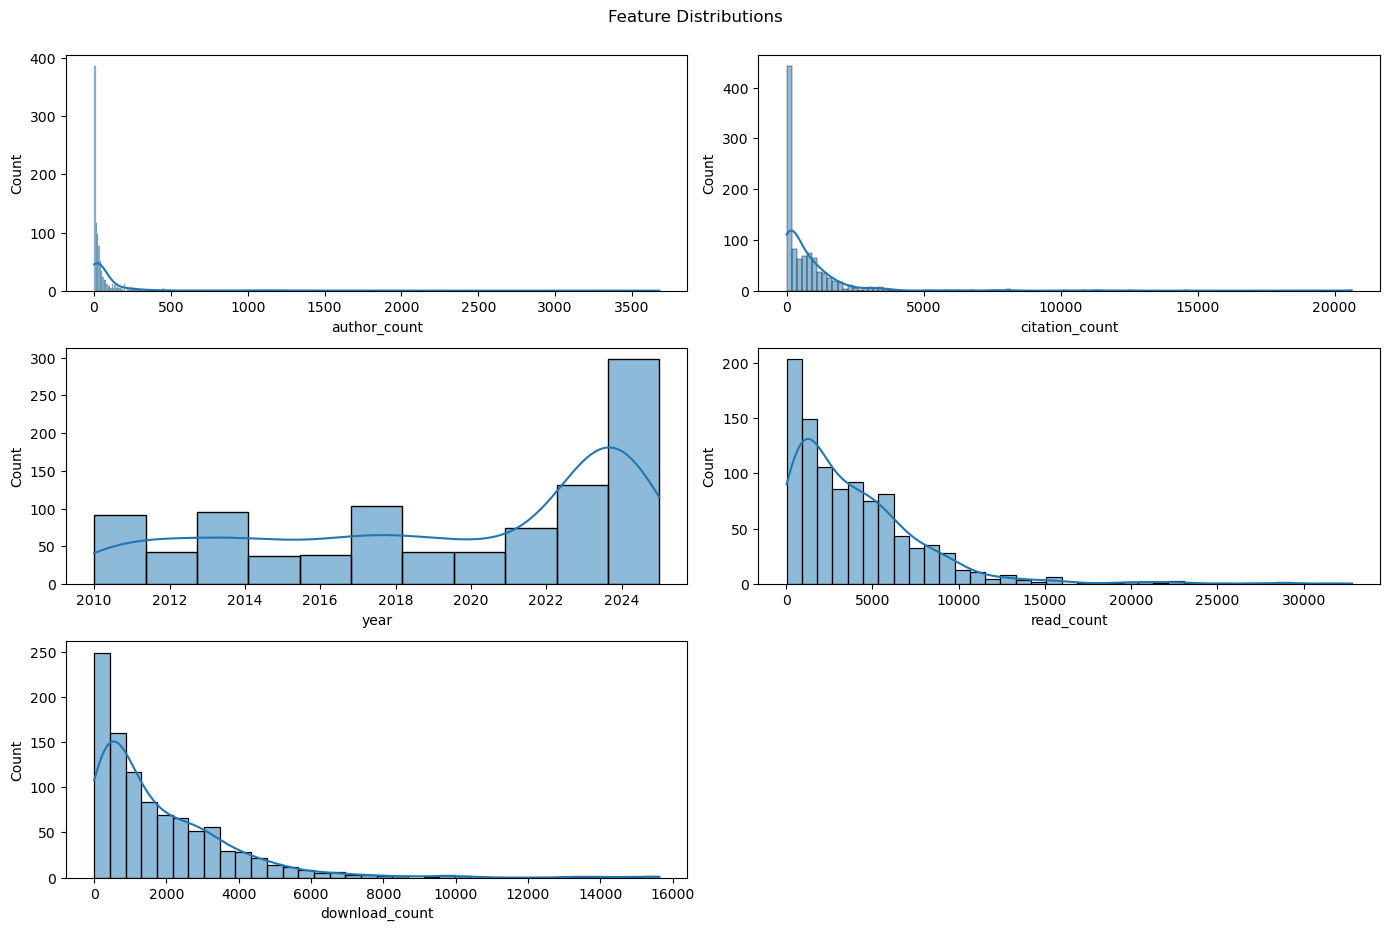

In [20]:
'''
Explore Feature Distributions
'''

data = pd.read_csv('../ads_data.csv')
numerical_cols = data.select_dtypes(include=[np.float64, np.int64]).columns
print('Numerical Columns:', numerical_cols)
fig = plt.figure(figsize=(14, len(numerical_cols)*3))
plt.suptitle('Feature Distributions')
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

<AxesSubplot:title={'center':'Feature Correlations'}>

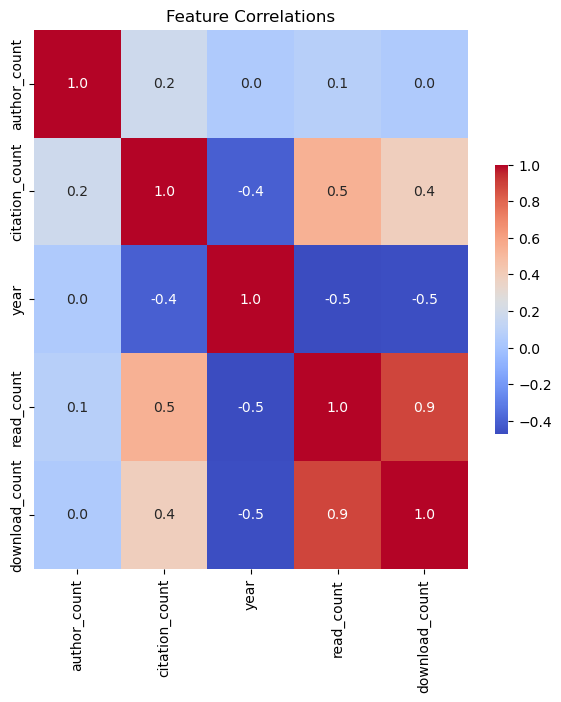

In [23]:
'''
Plot feature correlations
'''

data = pd.read_csv('../ads_data.csv')
corr = data[numerical_cols].corr()
fig = plt.figure(figsize=(7, 7))
plt.title('Feature Correlations')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={"shrink": 0.5})

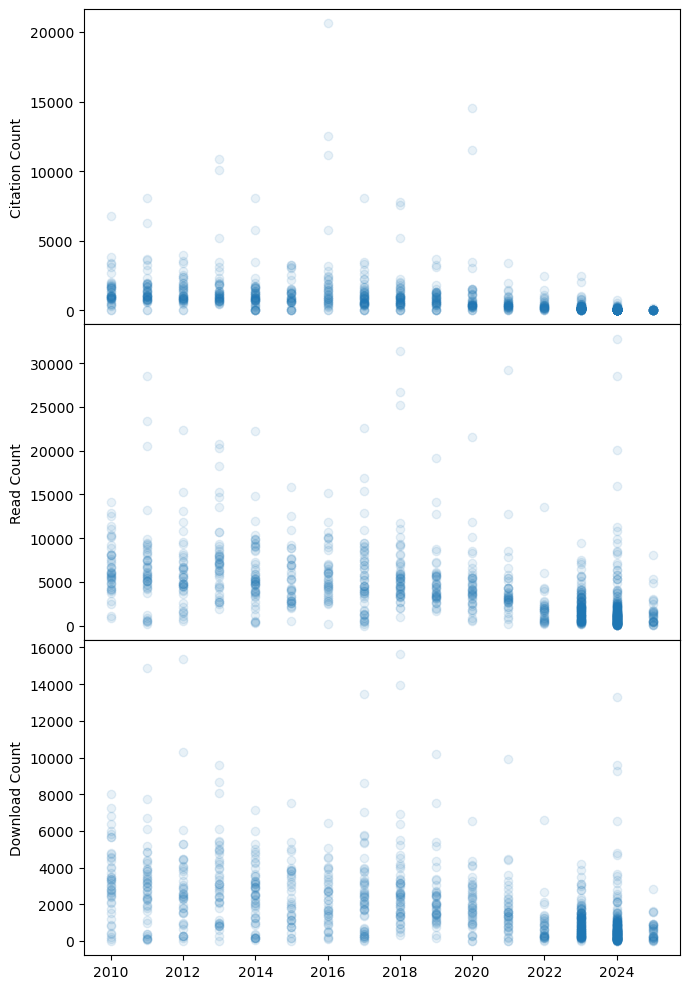

In [14]:
'''
Simple temporal analysis
'''

data = pd.read_csv('../ads_data.csv')
fig, axs = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
axs[0].scatter(data['year'], data['citation_count'], alpha=0.1, label='Citation Count')
axs[1].scatter(data['year'], data['read_count'], alpha=0.1,  label='Read Count')
axs[2].scatter(data['year'], data['download_count'], alpha=0.1, label='Download Count')
axs[0].set_ylabel('Citation Count')
axs[1].set_ylabel('Read Count')
axs[2].set_ylabel('Download Count')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [18]:
'''
Explore affiliations
'''

data = pd.read_csv('../ads_data.csv')
affs = []
for i in range(len(data)):
    print(data.iloc[i]['aff'])
    if i == 10:
        break
    # affiliations = data.iloc[i]['aff'].replace('[','').replace(']','').replace('\'','').split(', ')
    # affs = affs + affiliations
# affiliation_counts = pd.Series(affs).value_counts()
# print(affiliation_counts)

['-', '-']
['-', "Institut d'Astrophysique Spatiale, CNRS, Univ. Paris-Sud, Université Paris-Saclay, Bât. 121, 91405, Orsay Cedex, France", 'Département de Physique, École normale supérieure, PSL Research University, CNRS, 24 rue Lhomond, 75005, Paris, France; Institute Lorentz, Leiden University, PO Box 9506, Leiden, 2300 RA, The Netherlands; Institute of Theoretical Astrophysics, University of Oslo, Blindern, Oslo, Norway', 'Kavli Institute for Cosmology Cambridge, Madingley Road, Cambridge, CB3 0HA, UK; Astrophysics Group, Cavendish Laboratory, University of Cambridge, J J Thomson Avenue, Cambridge, CB3 0HE, UK', 'Université de Toulouse, UPS-OMP, IRAP, 31028, Toulouse Cedex 4, France', 'SISSA, Astrophysics Sector, Via Bonomea 265, 34136, Trieste, Italy', 'Department of Physics &amp; Astronomy, University of the Western Cape, Cape Town, 7535, South Africa; INAF - OAS Bologna, Istituto Nazionale di Astrofisica - Osservatorio di Astrofisica e Scienza dello Spazio di Bologna, Area della

Text(0, 0.5, 'Number of articles')

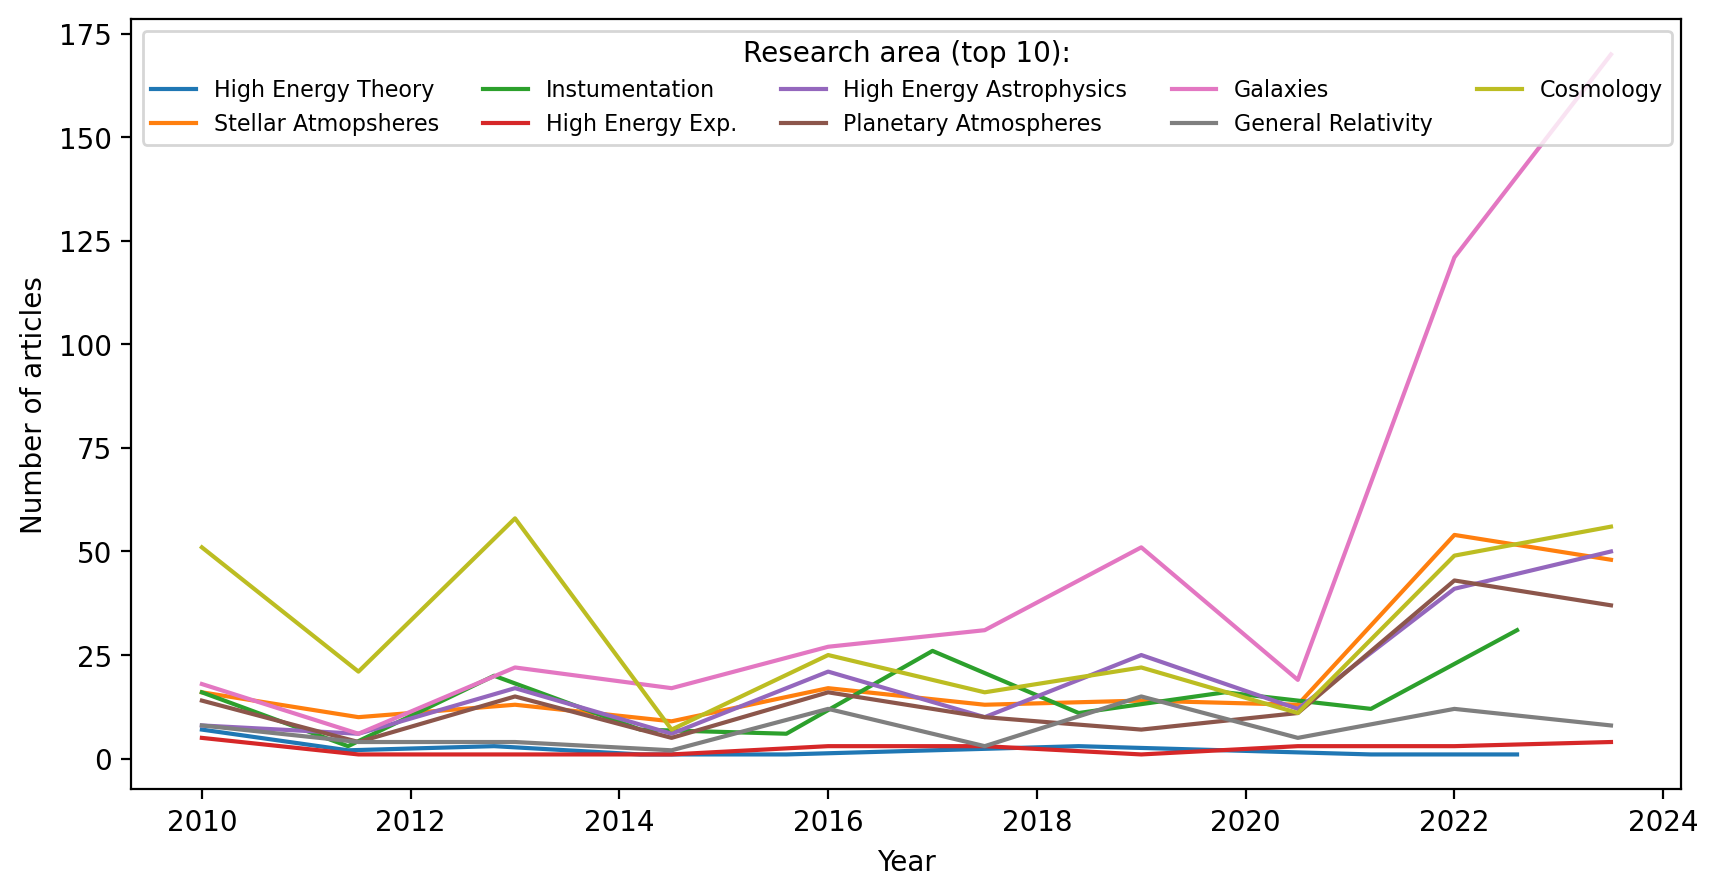

In [15]:
plt.figure(figsize = [10,5], dpi = 200)
arxiv_classes = list(set([item for sublist in [item.replace('\'','').replace('[','').replace(']','').replace(' ','').split(',') for item in data['arxiv_class']] for item in sublist]))
arxiv_classes.pop(0) # remove 'astro-ph' from list
labels = {'gr-qc':'General Relativity', 'astro-ph.EP':'Planetary Atmospheres','astro-ph.SR':'Stellar Atmopsheres', 'hep-ph':'High Energy Exp.', 'hep-th':'High Energy Theory', 'astro-ph.CO':'Cosmology', 'astro-ph.GA':'Galaxies', 'astro-ph.IM':'Instumentation', 'astro-ph.HE':'High Energy Astrophysics'}
for i in range(len(arxiv_classes)):
    arxiv_class = arxiv_classes[i]
    years = []
    for j in range(len(data)):
        if arxiv_class in data['arxiv_class'][j]:
            years += [data['year'][j]]
    counts, edges = np.histogram(years)
    if len(years) > 20:
        plt.plot(edges[:-1], counts, label = labels[arxiv_class])
    
plt.legend(title = 'Research area (top 10):', ncol = 5, fontsize = 8, loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Number of articles')

In [78]:
'''
Read in 
'''
N = 1e4
data_raw = pd.DataFrame(columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'])
i = 0
with open('../arxiv-metadata-oai-snapshot.json', 'r') as file:
    for line in file:
        if i < N:
            if 'astro' in row['categories']:
                i += 1
                row = json.loads(line)
                data_raw.loc[len(data_raw)] = {'id':row['id'], 'submitter':row['submitter'], 'authors':row['authors'], 'title':row['title'], 'comments':row['comments'], 'journal-ref':row['journal-ref'], 'doi':row['doi'], 'report-no':row['report-no'], 'categories':row['categories'], 'license':row['license'], 'abstract':row['abstract'], 'versions':row['versions'], 'update_date':row['update_date'], 'authors_parsed':row['authors_parsed']}
data_raw

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed


In [ ]:
data = pd.DataFrame(columns=['doi', 'num_authors', 'num_pages', 'year', 'categories'])
for i in range(len(data_raw)):
    row = data_raw.iloc[i]
    doi = row['doi']
    num_authors = len(row['authors_parsed'])
    comments = row['comments']
    if comments != None and 'pages' in comments:
        end = comments.find('pages')-1
        if end in [1,2,3]:
            start = 0 
        else:
            idx = end -1
            while comments[idx].isnumeric():
                idx = idx - 1
            start = idx + 1
        num_pages = comments[start:end]
    else:
        num_pages = None
    ref = row['journal-ref']
    year = ref[ref.find('(')+1:ref.find(')')] if ref != None and '(' in ref and ')' in ref else None
    categories = row['categories']
    data.loc[len(data)] = {'doi':doi, 'num_authors':num_authors, 'num_pages':num_pages, 'year':year, 'categories':categories}
data.to_csv('../arxiv_data.csv', index=False)
data

,doi,num_authors,num_pages,year,categories
0,10.1103/PhysRevD.76.013009,4,13,None,hep-ph
1,None,2,None,None,math.CO cs.CG
2,None,1,None,None,physics.gen-ph
3,None,1,None,None,math.CO
4,None,2,None,2008,math.CA math.FA
...,...,...,...,...,...
9995,10.1016/j.physc.2007.05.049,2,None,None,cond-mat.supr-con cond-mat.str-el
9996,None,1,None,None,hep-th
9997,None,1,None,2009,math.AG math.RT
9998,None,2,None,None,math.RT


Numerical Columns: Index(['num_authors'], dtype='object')


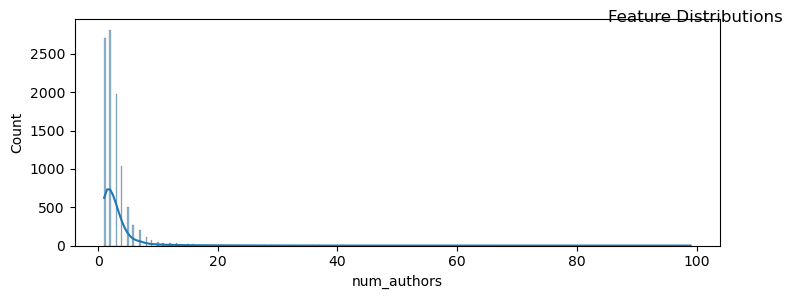

In [47]:
'''
Explore Feature Distributions
'''

data = pd.read_csv('../arxiv_data.csv')
numerical_cols = data.select_dtypes(include=[np.float64, np.int64]).columns
print('Numerical Columns:', numerical_cols)
fig = plt.figure(figsize=(14, len(numerical_cols)*3))
plt.suptitle('Feature Distributions')
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

#### ArXiv Data (using API)

In [90]:
'''
Create completely raw dataset (just for display)
'''


import arxiv
client = arxiv.Client()

data_raw = pd.DataFrame(columns=['doi', 'authors', 'comments', 'updated', 'categories'])
N_tot = 1000
count = 0
while count < N_tot:
    search = arxiv.Search(query="cat:astro-ph*", max_results=1000) 
    results = client.results(search); i=0
    for r in results:
        i += 1
        if count < N_tot:
            data_raw.loc[len(data_raw)] = {'doi':r.doi, 'authors':r.authors, 'comments':r.comment, 'updated':r.updated, 'categories':r.categories}
            count += 1
data_raw.to_csv('../arxiv_data_raw.csv', index=False)
data_raw

,doi,authors,comments,updated,categories
0,None,"[AAS WGLA, :, Nancy Brickhouse, John Cowan, Pa...",Position paper submitted by the AAS Working Gr...,2009-03-13 19:42:14+00:00,"[astro-ph.IM, astro-ph.CO, astro-ph.EP, astro-..."
1,None,"[Nancy Brickhouse, John Cowan, Paul Drake, Ste...",White Paper submitted by the AAS Working Group...,2009-03-26 14:08:20+00:00,"[astro-ph.IM, astro-ph.CO, astro-ph.EP, astro-..."
2,None,[Jonathan Arons],A White Paper submitted to the Astro 2010 Deca...,2009-03-27 19:31:02+00:00,"[astro-ph.HE, astro-ph.CO, astro-ph.EP, astro-..."
3,None,"[J. Lazio, J. S. Bloom, G. C. Bower, J. Cordes...",Astro2010 Decadal Survey Science white paper,2009-04-03 18:35:26+00:00,"[astro-ph.IM, astro-ph.CO, astro-ph.EP, astro-..."
4,10.1007/s00159-010-0032-2,[Michael G. Burton],Review paper on the field of Astronomy in Anta...,2010-07-13 22:49:00+00:00,"[astro-ph.IM, astro-ph.CO, astro-ph.EP, astro-..."
...,...,...,...,...,...
995,10.1093/mnras/staa1443,"[André M. Silva, Sérgio G. Sousa, Nuno Santos,...","14 pages, 13 figures, accepted for publication...",2020-05-26 09:37:30+00:00,"[astro-ph.IM, astro-ph.EP, astro-ph.SR]"
996,10.1051/0004-6361/201937059,"[Rasha Alshehhi, Kai Rodenbeck, Laurent Gizon,...",None,2020-05-26 20:52:44+00:00,"[astro-ph.EP, astro-ph.IM, astro-ph.SR]"
997,10.3847/1538-3881/ab8ae2,"[A. Mitrofanova, V. Dyachenko, A. Beskakotov, ...",None,2020-05-28 12:54:49+00:00,"[astro-ph.SR, astro-ph.EP, astro-ph.IM]"
998,10.3847/1538-3881/ab8bcc,"[Mary Knapp, Sara Seager, Brice-Olivier Demory...","23 pages, 9 figures. Accepted in AJ",2020-05-28 17:18:31+00:00,"[astro-ph.IM, astro-ph.EP, astro-ph.SR]"


In [2]:
'''
Create Useful Dataset
    - Using API client from https://pypi.org/project/arxiv/
'''

import arxiv
from word2number import w2n
client = arxiv.Client()

data = pd.DataFrame(columns=['doi', 'num_authors', 'num_pages', 'year', 'categories'])
N_tot = 1000
count = 0
while count < N_tot:
    search = arxiv.Search(query="cat:astro-ph*", max_results=1000) 
    results = client.results(search); i=0
    for r in results:
        i += 1
        if count < N_tot:
            comments = r.comment
            if comments != None and 'pages' in comments and r.doi != None: # LETS ONLY ADD IF NUM PAGES IS IN COMMENTS AND DOI IS NOT NONE
                comments = comments.replace('\n','').replace('  ',' ')
                end = comments.find('pages')-1
                if end in [1,2,3]:
                    start = 0 
                else:
                    idx = end -1
                    while comments[idx].isnumeric():
                        idx = idx - 1
                    start = idx + 1
                num_pages = comments[start:end]
                if type(num_pages) == str and '+' in num_pages:
                    num_pages = num_pages.split('+')
                    num_pages = sum([int(num) for num in num_pages])
                try:
                    num_pages = int(num_pages)
                except Exception:
                    try:
                        num_pages = w2n.word_to_num(num_pages)
                    except Exception:
                        print(f'Error with comment {i} "{comments}", gives start = {start}, stop = {end} num_pages = {comments[start:end]} --> skipping')
                        continue 
                year = int(r.updated.year)
                data.loc[len(data)] = {'doi':r.doi, 'num_authors':len(r.authors), 'num_pages':num_pages, 'year':year,  'categories':r.categories}
                count += 1
data.to_csv('../arxiv_data.csv', index=False)
data

UnexpectedEmptyPageError: Page of results was unexpectedly empty (https://export.arxiv.org/api/query?search_query=cat%3Aastro-ph%2A&id_list=&sortBy=relevance&sortOrder=descending&start=400&max_results=100)

Numerical Columns: Index(['num_authors', 'num_pages', 'year'], dtype='object')


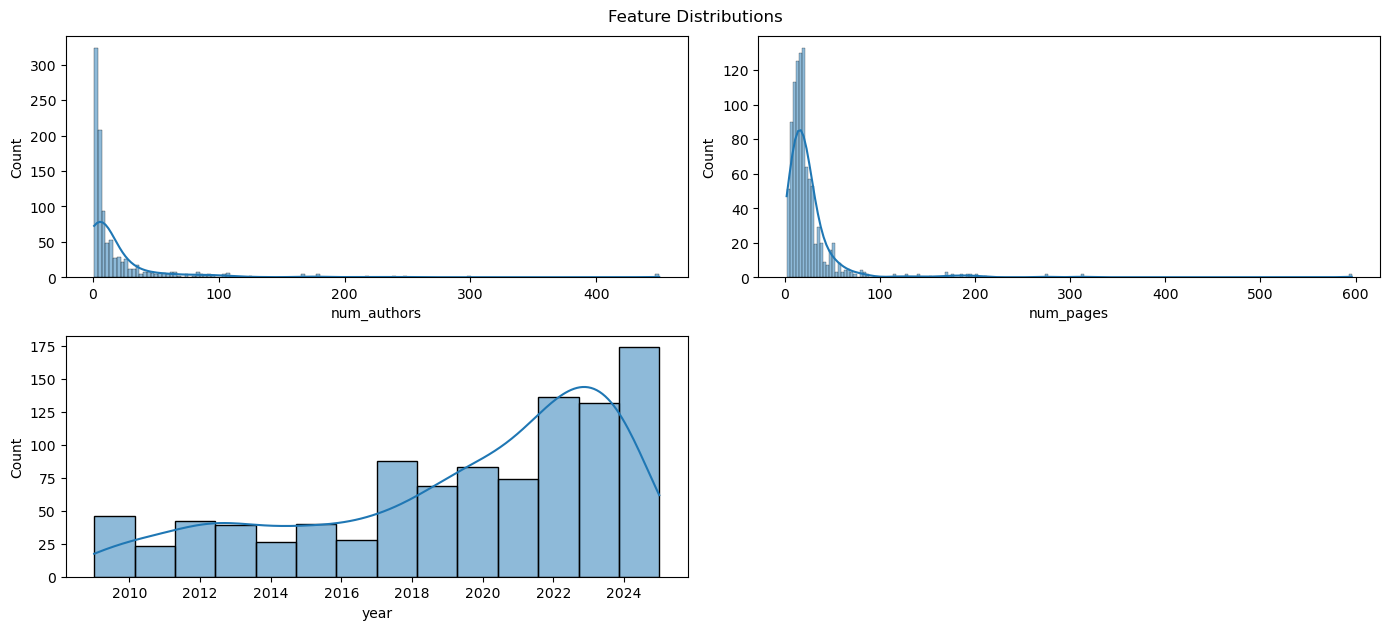

In [71]:
'''
Explore Feature Distributions
'''

data = pd.read_csv('../arxiv_data.csv')
numerical_cols = data.select_dtypes(include=[np.float64, np.int64]).columns
print('Numerical Columns:', numerical_cols)
fig = plt.figure(figsize=(14, len(numerical_cols)*3))
plt.suptitle('Feature Distributions')
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

#### Arxiv Data (using CSV)